In [1]:
pre_folder = r'M:\ISI result\HGA\LTS-02918\PRE\PRE.csv'
post_folder = r'M:\ISI result\HGA\LTS-02918\POST\POST.csv'
out_path = r'C:\HGA_ISI_ANALYSIS\ISI_HAST.xlsx'

In [2]:
import xlsxwriter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import openpyxl
from openpyxl.chart import BarChart3D,Reference

In [3]:
def res(pre,post):
    pchange = (((post-pre)*100)/pre)
    return(pchange)

def amp(pre,post):
    pchange = (((post-pre)*100)/pre)
    return(pchange)

def asym(pre,post):
    pchange = (post-pre)
    return(pchange)

def bj(pre,post):
    pchange = (post-pre)
    return(pchange)

def bju(pre,post):
    pchange = (((post-pre)*100)/pre)
    return(pchange)

def hys(pre,post):
    pchange = (post-pre)
    return(pchange)

def slp(pre,post):
    pchange = (((post-pre)*100)/pre)
    return(pchange)

def smm(pre,post):
    pchange = (((post-pre)*100)/pre)
    return(pchange)

def sma(pre,post):
    pchange = (((post-pre)*100)/pre)
    return(pchange)

def smr(pre,post):
    pchange = (((post-pre)*100)/pre)
    return(pchange)

def smn(pre,post):
    pchange = (post-pre)
    return(pchange)

In [4]:
pre=pd.read_csv(pre_folder)
pre['Hd&Part ID'] = pre['Hd']+pre['Part ID']
#grouppid = pre.groupby('Hd&Part ID')
#pre=grouppid[['Hd','Part ID','SBR','RESISTANCE','AMPLITUDE','ASYMETRY','BARK_JMP','BARK_JMP_UV','HYSTERESIS','SLOPE','SMANMAX_MAX','SMANAMP_AVG','SMANRMS_AVG','SMAN_NORM']].tail(1)

In [5]:
prescreen = pre.loc[(pre['RESISTANCE'] < 100)|(pre['RESISTANCE'] > 1000)]
pre = pre.loc[(pre['RESISTANCE'] > 100)&(pre['RESISTANCE'] < 1000)]

In [6]:
post=pd.read_csv(post_folder)
post['Hd&Part ID'] = post['Hd']+post['Part ID']
grouppid = post.groupby('Hd&Part ID')
post=grouppid[['Hd','Part ID','RESISTANCE','AMPLITUDE','ASYMETRY','BARK_JMP','BARK_JMP_UV','HYSTERESIS','SLOPE','SMANMAX_MAX','SMANAMP_AVG','SMANRMS_AVG','SMAN_NORM']].tail(1)

In [7]:
pre_post = pd.merge(pre,post,how='left', on=['Hd','Part ID'])

In [8]:
pre_post['%dMRE'] = res(pre_post.RESISTANCE_x,pre_post.RESISTANCE_y)
pre_post['%dAMP'] = amp(pre_post.AMPLITUDE_x, pre_post.AMPLITUDE_y)
pre_post['%dASYM'] = asym(pre_post.ASYMETRY_x, pre_post.ASYMETRY_y)
pre_post['%dBJ'] = bj(pre_post.BARK_JMP_x, pre_post.BARK_JMP_y)
pre_post['%dBJU'] = bju(pre_post.BARK_JMP_UV_x, pre_post.BARK_JMP_UV_y)
pre_post['%dHYS'] = hys(pre_post.HYSTERESIS_x, pre_post.HYSTERESIS_y)
pre_post['%dSLP'] = slp(pre_post.SLOPE_x, pre_post.SLOPE_y)
pre_post['%dSMM'] = smm(pre_post.SMANMAX_MAX_x, pre_post.SMANMAX_MAX_y)
pre_post['%dSMA'] = sma(pre_post.SMANAMP_AVG_x, pre_post.SMANAMP_AVG_y)
pre_post['%dSMR'] = smr(pre_post.SMANRMS_AVG_x, pre_post.SMANRMS_AVG_y)
pre_post['%dSMN'] = smn(pre_post.SMAN_NORM_x, pre_post.SMAN_NORM_y)

In [9]:
missingid = pre_post[pre_post['%dMRE'].isnull()]
missing = pre_post.dropna(subset=['%dMRE'])
pre_post = missing

In [10]:
pre_post.loc[abs(pre_post['%dMRE'])>10,'DISPOSITION'] = "RES"
pre_post.loc[(abs(pre_post['%dMRE'])<10)&(abs(pre_post['%dAMP'])>20),'DISPOSITION'] = "AMP"
pre_post.loc[(abs(pre_post['%dMRE'])<10)&(abs(pre_post['%dAMP'])<20)&(abs(pre_post['%dASYM'])>10),'DISPOSITION'] = "ASYM"
pre_post.loc[(abs(pre_post['%dMRE'])<10)&(abs(pre_post['%dAMP'])<20)&(abs(pre_post['%dASYM'])<10)&(abs(pre_post['%dBJ'])>50)&(abs(pre_post['BARK_JMP_y'])>15),'DISPOSITION'] = "BARK_JMP"
pre_post.loc[(abs(pre_post['%dMRE'])<10)&(abs(pre_post['%dAMP'])<20)&(abs(pre_post['%dASYM'])<10)&(abs(pre_post['%dBJ'])<50)&(abs(pre_post['BARK_JMP_y'])<15)&(abs(pre_post['%dSMM'])>50)&(abs(pre_post['SMAN_NORM_y'])>30),'DISPOSITION'] = "SMAN"
pre_post.loc[(abs(pre_post['%dMRE'])<10)&(abs(pre_post['%dAMP'])<20)&(abs(pre_post['%dASYM'])<10)&(abs(pre_post['%dBJ'])<50)&(abs(pre_post['BARK_JMP_y'])<15)&(abs(pre_post['%dSMM'])<50)&(abs(pre_post['SMAN_NORM_y'])<30)&(pre_post['SLOPE_x']>0)&(pre_post['SLOPE_y']>0),'DISPOSITION'] = "SLOPE"

In [11]:
pre_post["DISPOSITION"].fillna("NORMAL", inplace = True)

In [12]:
table = pd.pivot_table(pre_post, values='Part ID', index=['SBR'], columns=['DISPOSITION'], aggfunc='count', margins=False)

In [13]:
table['SAMPLE'] = table.sum(axis = 1)
table['%FAIL_RATE'] = (table['SAMPLE']-table['NORMAL'])/table['SAMPLE']*100

In [14]:
PRE_SUM = pre.groupby(['SBR','Hd']).agg({'RESISTANCE': ['count','mean','std'],'AMPLITUDE': ['mean','std'],'ASYMETRY': ['mean','std'],'BARK_JMP': ['mean','std'],'HYSTERESIS': ['mean','std'],'SLOPE': ['mean','std'],'SMANMAX_MAX': ['mean','std'],'SMANAMP_AVG': ['mean','std'],'SMANRMS_AVG': ['mean','std'],'SMAN_NORM': ['mean','std']})


In [15]:
PRE_SUM = pd.DataFrame(PRE_SUM)
PRE_SUM = PRE_SUM.T

In [16]:
writer = pd.ExcelWriter(out_path, engine='xlsxwriter')

In [17]:
pre_post.to_excel(writer, sheet_name='ALL', index=None)
prescreen.to_excel(writer, sheet_name='PRE_SCREENING')
PRE_SUM.to_excel(writer, sheet_name='PRELIM')
missingid.to_excel(writer, sheet_name='MISSING_DATA')
table.to_excel(writer, sheet_name='FAIL_RATE')

In [18]:
writer.save()

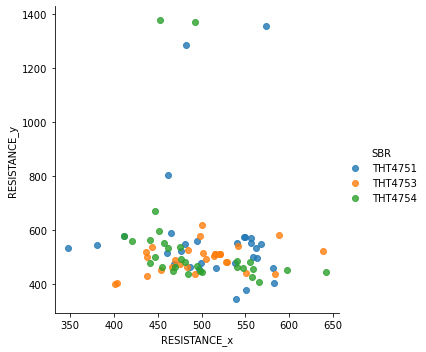

In [19]:
corr = sns.lmplot( x="RESISTANCE_x", y="RESISTANCE_y", data=pre_post, fit_reg=False, hue='SBR', legend=True)
